<a href="https://colab.research.google.com/github/minjeon99/ESAA-10th-OB/blob/Week2/w2_mon_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


# **07 앙상블 학습과 랜덤 포레스트**

- 앙상블 학습: 좋은 모델 하나보다 일련의 예측기(분류, 회귀 모델)로부터 수집한 예측이 더 좋은 예측을 얻을 수 있음
  - 훈련 세트에서 여러 서브셋 생성, 결정트리 분류기를 훈련시켜 개별 트리에서 예측 구하기  -> 가장 많은 선택을 받은 클래스로 선택
- 랜덤 포레스트: 결정 트리의 앙상블

## **7.1 투표 기반 분류기**

- hard voting: 다수결 투표로 최종 클래스 예측
- 각 분류기가 weak learner(랜덤 추측보다 조금 더 높은 성능의 분류기)일지라도, 충분하게 많고 다양하다면 앙상블은 strong learner가 될 수 있음
  - "큰 수의 법칙" 때문
  - (모든 분류기가 완벽하게 독립적, 오차에 상관관계 없다는 가정) 51% 정확도를 가진 1,000개의 분류기로 앙상블 => 75%의 정확도
  - (But) 같은 데이터로 훈련시키기 때문에 가정 성립 X
    - 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고, 앙상블 정확도 하락
  - 앙상블: 각 예측기가 가능한 한 서로 **독립적**일 때 최고 성능 발휘

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.912


- Voting 분류기가 개별 분류기보다 성능이 조금 더 높음

- soft voting: 개별 분류기의 예측(확률)을 평균 -> 확률이 가장 높은 클래스 예측
  - hard voting보다 더 높은 성능
  - `voting='soft'`
  - SVC: `probability=True`



## **7.2 배깅과 페이스팅**

다양한 분류기를 만드는 방법
1. 다른 훈련 알고리즘 사용
2. 다른 훈련 데이터 사용
- 배깅(bagging): 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅(pasting): 중복을 허용하지 않고 샘플링

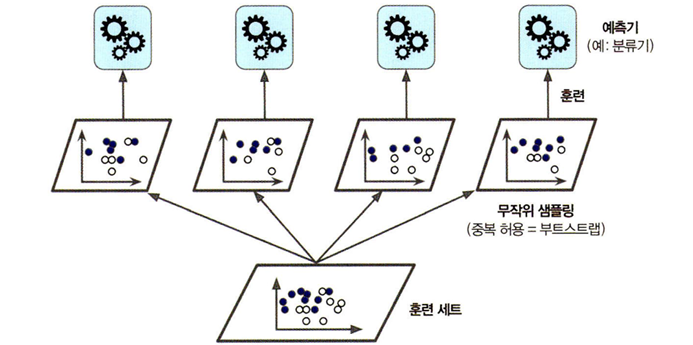

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측 생성
- (일반적인) 수집함수
  - 분류 -> 통계적 최빈값
  - 회귀 -> 평균
- 개별 예측기는 원본 훈련 세트로 훈련시킬 경우보다 훨씬 큰 편향,

  But 수집함수를 통과하면 편향&분산 모두 감소
  - 일반적으로, 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 편향은 비슷, 분산은 감소

### **7.2.1 사이킷런의 배깅과 페이스팅**

- 사이킷런의 `BaggingClassifier`

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 결정 트리 분류기 500개의 앙상블 훈련시키기
  - 훈련 세트에서 중복을 허용하여(Bagging) 무작위로 선택된 100개의 샘플로 훈련
    - pasting: `bootstrap=False` 지정
  - `n_jobs`: 사용할 CPU 코어 수 (-1: 가용한 모든 코어 사용)

- 단일 결정 트리와 500개 트리를 사용한 배깅 앙상블의 결정 경계 비교

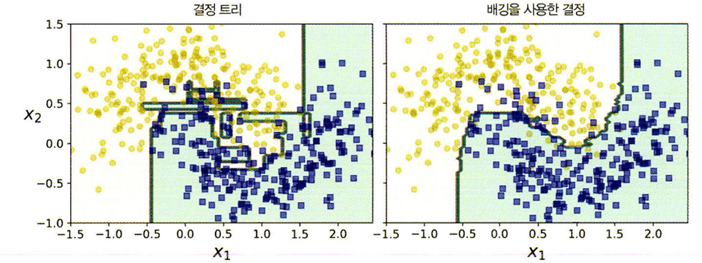
  - 앙상블의 예측이 더 일반화 잘 됨
    - 비슷한 편향에서 더 작은 분산 만들기

      (훈련 세트의 오차 수는 거의 비슷하나, 덜 불규칙한 결정 경계)

### **7.2.2 oob 평가**

BaggingClassifier: 중복을 허용하여 m개 샘플(훈련 세트의 크기) 선택 => 각 예측기에 훈련 샘플의 63% 정도만 샘플링
- 선택되지 않은 나머지 37% = out-of-bag(oob) 샘플
  - 예측기마다 남겨진 37%는 모두 다름
- 예측기가 훈련되는 동안 oob 샘플을 사용하지 않으므로, 별도의 검증 세트 대신 oob 샘플로 평가할 수 있음
- `oob_score=True`: 훈련 끝난 후 자동으로 oob 평가 수행

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

- oob 평가 결과를 보면 약 89.3%의 정확도를 얻을 것으로 보임

In [12]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.888

- 테스트 세트에서 88.8%의 정확도를 얻음
  - 비슷한 결과
- `oob_decision_function_`: oob 샘플에 대한 결정 함수의 값

In [13]:
bag_clf.oob_decision_function_

array([[0.40659341, 0.59340659],
       [0.40816327, 0.59183673],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.0964467 , 0.9035533 ],
       [0.31176471, 0.68823529],
       [0.00549451, 0.99450549],
       [0.99418605, 0.00581395],
       [0.98113208, 0.01886792],
       [0.82035928, 0.17964072],
       [0.00591716, 0.99408284],
       [0.7607362 , 0.2392638 ],
       [0.86910995, 0.13089005],
       [0.97560976, 0.02439024],
       [0.06486486, 0.93513514],
       [0.01015228, 0.98984772],
       [0.98453608, 0.01546392],
       [0.94054054, 0.05945946],
       [0.99447514, 0.00552486],
       [0.015625  , 0.984375  ],
       [0.34391534, 0.65608466],
       [0.90285714, 0.09714286],
       [1.        , 0.        ],
       [0.95833333, 0.04166667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.69109948, 0.30890052],
       [0.

## **7.3 랜덤 패치와 랜덤 서브스페이스**

- BaggingClassfier은 특성 샘플링도 지원
  - `max_features`, `bootstrap_features` 두 매개변수로 조절
  - 무작위로 선택한 입력 특성의 일부분으로 훈련
- (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용
- 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링
- 랜덤 서브스페이스 방식: 훈련 샘플은 모두 사용(`bootstrap=False, max_samples=1.0`), 특성은 샘플링
- 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

## **7.4 랜덤 포레스트**

- 랜덤 포레스트: 일반적으로 배깅(또는 페이스팅)을 적용한 결정 트리의 앙상블
  - max_samples를 훈련 세트의 크기로 지정
  - 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트 알고리즘은 트리 노드 분할 시 전체 특성 중 최선의 특성을 찾는 대신,

  무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입
  - 더 다양한 트리를 만들고, 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델 만들기

In [16]:
# BaggingClassifier를 사용해 RandomForestClassifier와 유사하게 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### **7.4.1 엑스트라 트리**

트리를 만들 때 각 노드는 무작위로 특성의 서브넷을 만들어 분할에 사용
- 엑스트라 트리 = 익스트림 랜덤 트리(extremely randomized trees): 극단적으로 무작위한 트리의 랜덤 포레스트
  - 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할 -> 최상의 분할 선택

### **7.4.2. 특성 중요도**

- 랜덤 포레스트의 또 다른 장점: 특성의 상대적 중요도를 측정하기 쉬움

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09580215025836364
sepal width (cm) 0.02393147269329948
petal length (cm) 0.46406621833197914
petal width (cm) 0.41620015871635774


## **7.5 부스팅**

- 부스팅(boosting): 약한 학습기를 여러 개 연결 -> 강한 학습기 만드는 앙상블 방법

### **7.5.1 에이다부스트**

- 이전 모델이 과소적합했던 훈련 샘플의 가중치 높이기 => 학습하기 어려운 샘플에 점점 더 맞춰지게 됨

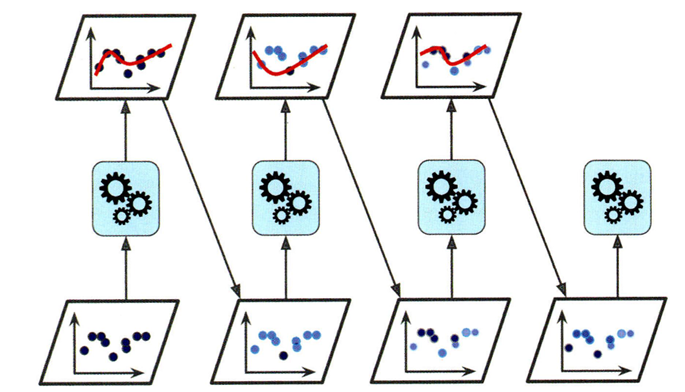

### **7.5.2 그레이디언트 부스팅**

- 에이다부스트: 반복마다 샘플의 가중치 수정
- 그레이디언트 부스팅: 이전 예측기가 만든 잔차(residual error)에 새로운 예측기를 학습시키기
- gradient tree boosting = gradient boosted regression tree(GBRT)

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [19]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [20]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [27]:
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

- 사이킷런을 이용한 GBRT 앙상블

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=110)

In [30]:
# early stopping 구현하기

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break

- 확률적 그레이디언트 부스팅: 각 트리가 훈련할 때 사용할 훈련 샘플의 비율 지정 -> 무작위로 선택된 n%의 훈련 샘플로 학습
- XGBoost: extreme gradient boosting의 약자

In [35]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [36]:
# early stopping도 지원
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.39935
[1]	validation_0-rmse:0.34589
[2]	validation_0-rmse:0.31841
[3]	validation_0-rmse:0.30201
[4]	validation_0-rmse:0.29526
[5]	validation_0-rmse:0.29241
[6]	validation_0-rmse:0.29242


## **7.6 스태킹**

- 스태킹
  - 예측기들의 예측을 취합하는 간단한 함수(ex. voting)를 사용하는 대신, 취합하는 모델을 훈련시키자
  - blender = meta learner(메타 학습기): 마지막 예측기
- 홀드 아웃 세트 이용